In [1]:
import numpy as np
import jax, jax.numpy as jp
import matplotlib.pyplot as plt

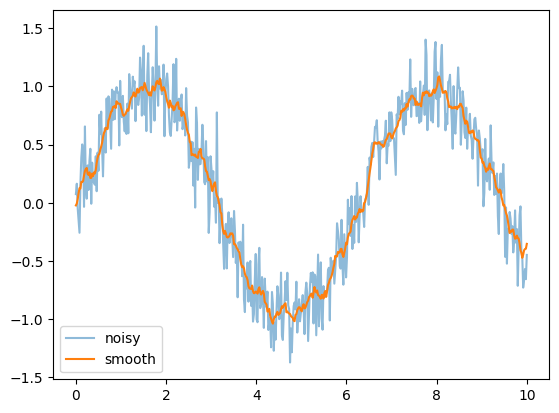

In [6]:
rng = jax.random.PRNGKey(0)
x = jp.linspace(0, 10, 500)
y = jp.sin(x) + 0.2 * jax.random.normal(rng, (500, ))

window = jp.ones(10) / 10
y_smooth = jp.convolve(y, window, mode='same')

plt.plot(x, y, alpha=0.5, label='noisy')
plt.plot(x, y_smooth, label='smooth')
plt.legend()

/tmp/ipykernel_716763/1905282640.py:5: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = jp.array(misc.face(gray=True))


Text(0.5, 1.0, 'smooth')

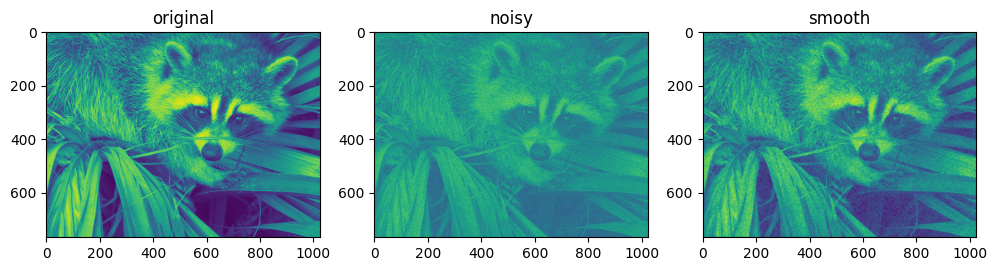

In [15]:
from scipy import misc
import jax.scipy as js

fix, ax = plt.subplots(1, 3, figsize=(12, 5))
img = jp.array(misc.face(gray=True))

ax[0].imshow(img)
ax[0].set_title('original')

noisy_img = img + 50 * jax.random.normal(rng, img.shape)
ax[1].imshow(noisy_img)
ax[1].set_title('noisy')

x = jp.linspace(-3, 3, 7)
window = js.stats.norm.pdf(x) * js.stats.norm.pdf(x[:, None])
# window = jp.expand_dims(window, -1)
smooth_img = js.signal.convolve(noisy_img, window, mode='same')
ax[2].imshow(smooth_img)
ax[2].set_title('smooth')

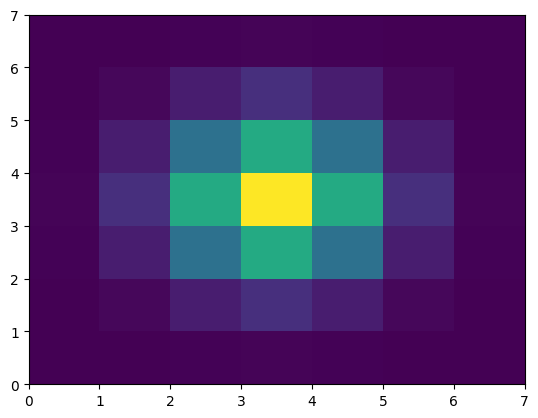

In [16]:
plt.pcolormesh(window)

(3, 3, 3, 3)


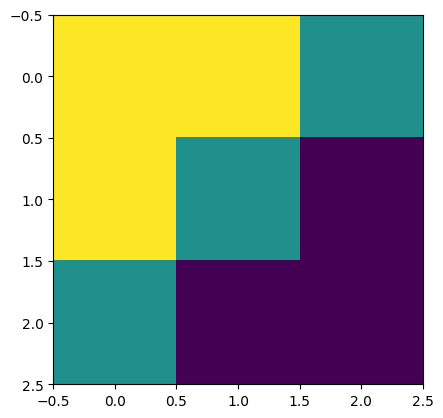

In [19]:
kernel = jp.zeros((3, 3, 3, 3), dtype=jp.float32)
kernel += jp.array([[1, 1, 0],
                    [1, 0, -1],
                    [0, -1, -1]])[:, :, None, None]

print(kernel.shape)
plt.imshow(kernel[:, :, 0, 0])

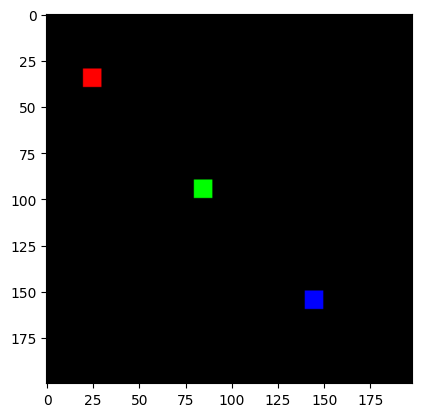

In [20]:
img = jp.zeros((1, 200, 198, 3), dtype=jp.float32)
for k in range(3):
    x = 30 + 60 * k
    y = 20 + 60 * k
    img = img.at[0, x:x+10, y:y+10, k].set(1.0)

plt.imshow(img[0])

(1, 3, 200, 198)


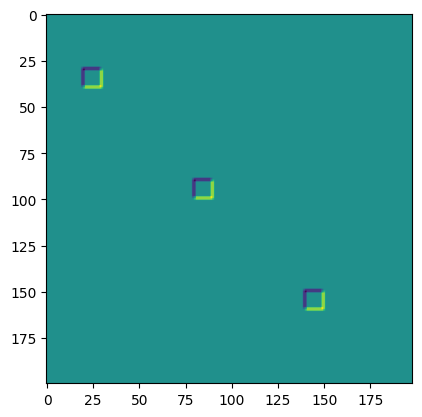

In [23]:
out = jax.lax.conv(
    # lax.conv only supports NCHW input, OIHW kernel
    img.transpose(0, 3, 1, 2),
    kernel.transpose(3, 2, 0, 1),
    window_strides=(1, 1),
    padding='same'
)

print(out.shape)
plt.imshow(np.array(out[0, 0, :, :]))

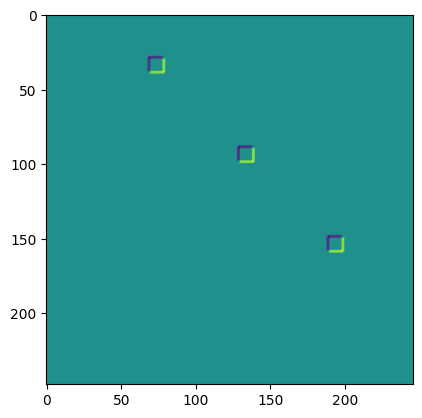

In [33]:
out = jax.lax.conv_with_general_padding(
    img.transpose(0, 3, 1, 2),
    kernel.transpose(3, 2, 0, 1),
    window_strides=(1, 1),
    padding=[(0, 50), (50, 0)],
    lhs_dilation=(1, 1),
    rhs_dilation=(1, 1),
)

plt.imshow(np.array(out[0, 0, :, :]))

In [34]:
dn = jax.lax.conv_dimension_numbers(
    img.shape,
    kernel.shape,
    ('NHWC', 'HWIO', 'NHWC')    # input, kernel, output
)

print(dn)   # transpose ids to convert to NCHW, OIHW, NCHW

ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2))


(1, 200, 198, 3)


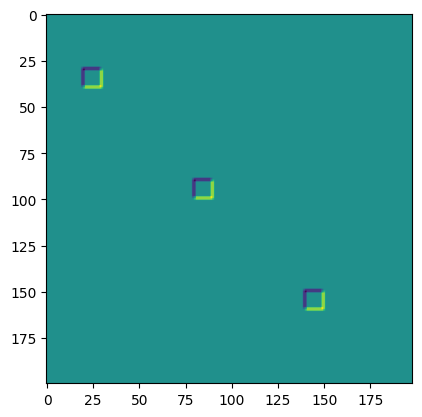

In [36]:
out = jax.lax.conv_general_dilated(
    img, kernel, (1, 1), 'SAME', (1, 1), (1, 1), dn
)

print(out.shape)
plt.imshow(np.array(out[0, :, :, 0]))

(1, 180, 178, 3)


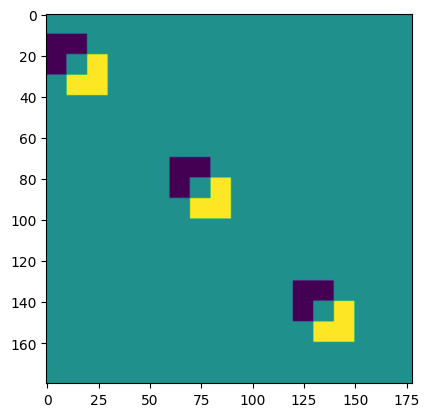

In [55]:
out = jax.lax.conv_general_dilated(
    img, kernel, window_strides=(1, 1), padding='valid',
    lhs_dilation=(1, 1),
    rhs_dilation=(10, 10),
    dimension_numbers=dn
)

print(out.shape)
plt.imshow(np.array(out[0, :, :, 0]))

In [71]:
x = jp.arange(125).reshape(5, 5, 5).astype(jp.float32)[None, None, ...]
print(x)
print(x.shape)

[[[[[  0.   1.   2.   3.   4.]
    [  5.   6.   7.   8.   9.]
    [ 10.  11.  12.  13.  14.]
    [ 15.  16.  17.  18.  19.]
    [ 20.  21.  22.  23.  24.]]

   [[ 25.  26.  27.  28.  29.]
    [ 30.  31.  32.  33.  34.]
    [ 35.  36.  37.  38.  39.]
    [ 40.  41.  42.  43.  44.]
    [ 45.  46.  47.  48.  49.]]

   [[ 50.  51.  52.  53.  54.]
    [ 55.  56.  57.  58.  59.]
    [ 60.  61.  62.  63.  64.]
    [ 65.  66.  67.  68.  69.]
    [ 70.  71.  72.  73.  74.]]

   [[ 75.  76.  77.  78.  79.]
    [ 80.  81.  82.  83.  84.]
    [ 85.  86.  87.  88.  89.]
    [ 90.  91.  92.  93.  94.]
    [ 95.  96.  97.  98.  99.]]

   [[100. 101. 102. 103. 104.]
    [105. 106. 107. 108. 109.]
    [110. 111. 112. 113. 114.]
    [115. 116. 117. 118. 119.]
    [120. 121. 122. 123. 124.]]]]]
(1, 1, 5, 5, 5)


In [73]:
y = jax.lax.conv_general_dilated_patches(
    x,
    filter_shape=(2, 2, 2),
    window_strides=(2, 1, 1),
    padding='valid',
)
print(y.shape)
print(y)

(1, 8, 2, 4, 4)
[[[[[ 0.  1.  2.  3.]
    [ 5.  6.  7.  8.]
    [10. 11. 12. 13.]
    [15. 16. 17. 18.]]

   [[50. 51. 52. 53.]
    [55. 56. 57. 58.]
    [60. 61. 62. 63.]
    [65. 66. 67. 68.]]]


  [[[ 1.  2.  3.  4.]
    [ 6.  7.  8.  9.]
    [11. 12. 13. 14.]
    [16. 17. 18. 19.]]

   [[51. 52. 53. 54.]
    [56. 57. 58. 59.]
    [61. 62. 63. 64.]
    [66. 67. 68. 69.]]]


  [[[ 5.  6.  7.  8.]
    [10. 11. 12. 13.]
    [15. 16. 17. 18.]
    [20. 21. 22. 23.]]

   [[55. 56. 57. 58.]
    [60. 61. 62. 63.]
    [65. 66. 67. 68.]
    [70. 71. 72. 73.]]]


  [[[ 6.  7.  8.  9.]
    [11. 12. 13. 14.]
    [16. 17. 18. 19.]
    [21. 22. 23. 24.]]

   [[56. 57. 58. 59.]
    [61. 62. 63. 64.]
    [66. 67. 68. 69.]
    [71. 72. 73. 74.]]]


  [[[25. 26. 27. 28.]
    [30. 31. 32. 33.]
    [35. 36. 37. 38.]
    [40. 41. 42. 43.]]

   [[75. 76. 77. 78.]
    [80. 81. 82. 83.]
    [85. 86. 87. 88.]
    [90. 91. 92. 93.]]]


  [[[26. 27. 28. 29.]
    [31. 32. 33. 34.]
    [36. 37. 38. 39.]
    [41.